In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

import tensorflow_hub
tf.test.is_built_with_cuda()

False

In [2]:
import os

# Đi vào thư mục pizza_steak và xem từng file
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"Có {len(dirnames)} thư mục và {len(filenames)} hình ảnh trong '{dirpath}'.")

Có 2 thư mục và 0 hình ảnh trong 'pizza_steak'.
Có 2 thư mục và 0 hình ảnh trong 'pizza_steak\test'.
Có 0 thư mục và 250 hình ảnh trong 'pizza_steak\test\pizza'.
Có 0 thư mục và 250 hình ảnh trong 'pizza_steak\test\steak'.
Có 2 thư mục và 0 hình ảnh trong 'pizza_steak\train'.
Có 0 thư mục và 750 hình ảnh trong 'pizza_steak\train\pizza'.
Có 0 thư mục và 750 hình ảnh trong 'pizza_steak\train\steak'.


Trong tập dữ liệu có 1500 ảnh train và 500 ảnh test


In [3]:
# Lấy label trong data
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) 
print(class_names)

['pizza' 'steak']


Hiển thị hình ảnh 

In [4]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  # Lấy một đường dẫn hình ảnh ngẫu nhiên
  random_image = random.sample(os.listdir(target_folder), 1)

  # Đọc hình ảnh sử dụng matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  print(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # Hiển thị shape ảnh 

  return img

# Vẽ validation và training data 
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

pizza_steak/train/steak/2344227.jpg
Image shape: (384, 512, 3)
pizza_steak/train/pizza/1636299.jpg
Image shape: (512, 512, 3)


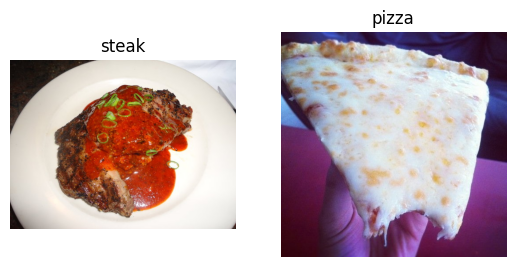

In [5]:
# Visualize data 
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

In [6]:


# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)



Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


## Training model

In [7]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 39s 812ms/step - loss: 0.6096 - accuracy: 0.6773 - val_loss: 0.5075 - val_accuracy: 0.7620
Epoch 2/5
47/47 [==============================] - 37s 798ms/step - loss: 0.4595 - accuracy: 0.7927 - val_loss: 0.3617 - val_accuracy: 0.8560
Epoch 3/5
47/47 [==============================] - 38s 802ms/step - loss: 0.3721 - accuracy: 0.8467 - val_loss: 0.3404 - val_accuracy: 0.8380
Epoch 4/5
47/47 [==============================] - 38s 806ms/step - loss: 0.3277 - accuracy: 0.8693 - val_loss: 0.3255 - val_accuracy: 0.8620
Epoch 5/5
47/47 [==============================] - 38s 801ms/step - loss: 0.2262 - accuracy: 0.9147 - val_loss: 0.2679 - val_accuracy: 0.8900


from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://my_site.com/my_picture.jpg")

In [10]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

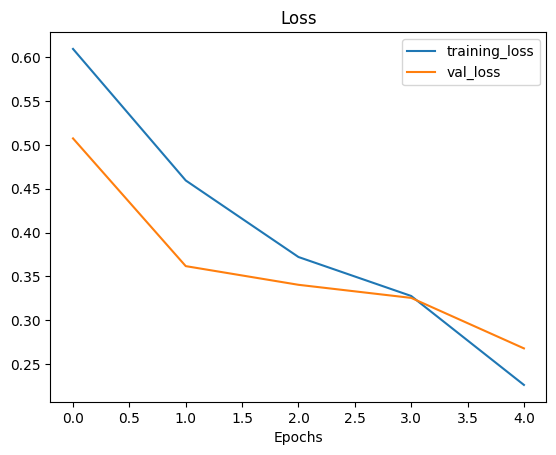

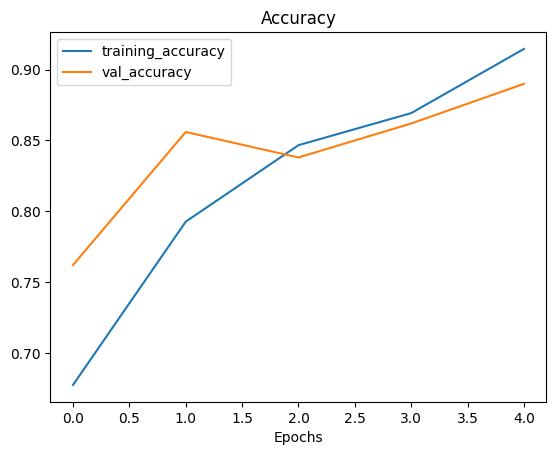

In [8]:
plot_loss_curves(history_1)

In [30]:
model_1.evaluate(valid_data)

16/16 [==============================] - 1s 69ms/step - loss: 0.3531 - accuracy: 0.8760


[0.3530995547771454, 0.8759999871253967]

In [34]:
np.save('history_2.npy',history_1.history)

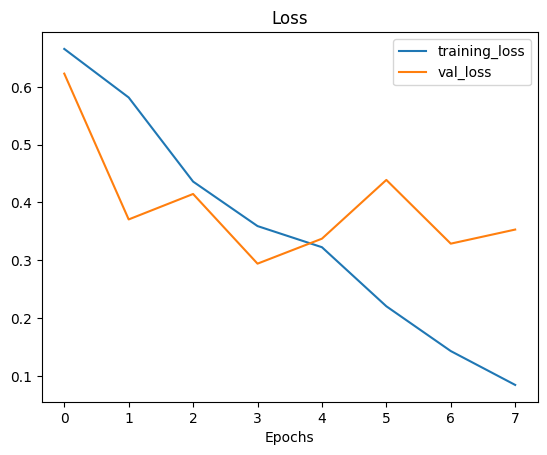

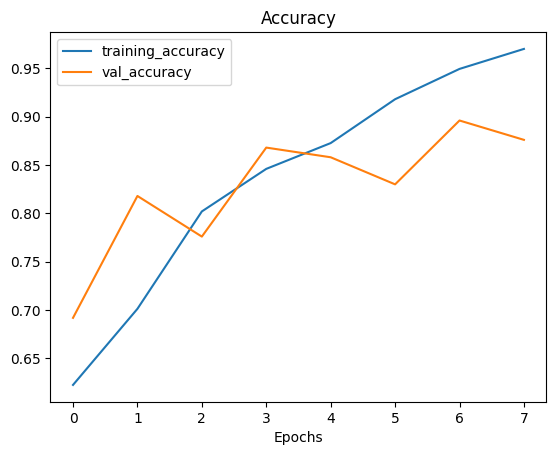

In [35]:
history_load=np.load('history_2.npy',allow_pickle='TRUE').item()
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history['loss']
  val_loss = history['val_loss']

  accuracy = history['accuracy']
  val_accuracy = history['val_accuracy']

  epochs = range(len(history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
plot_loss_curves(history_load)


## Dự đoán 

In [14]:
# Classes we're working with
print(class_names)

['pizza' 'steak']


In [15]:
def load_and_prep_image(filename, img_shape=224):
  """
  Đọc hình ảnh và biến dữ liệu thành tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  
  return img

img = load_and_prep_image("test.jpg")
img = tf.expand_dims(img, axis=0)
# pizza.shape
pred = model_1.predict(img)
pred

1/1 [==============================] - 0s 297ms/step


array([[0.5893658]], dtype=float32)

In [16]:
# Adjust function to work with multi-class


1/1 [==============================] - 0s 32ms/step


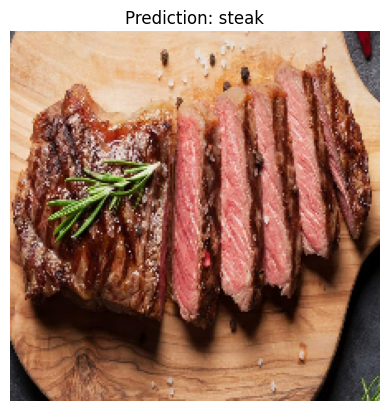

In [17]:
from helper_functions import pred_and_plot
pred_and_plot(model_1,'test.jpg',class_names)

## Multi-class Classification


In [11]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"


Get  class names

In [12]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Hiển thị hình ảnh

Image shape: (512, 512, 3)


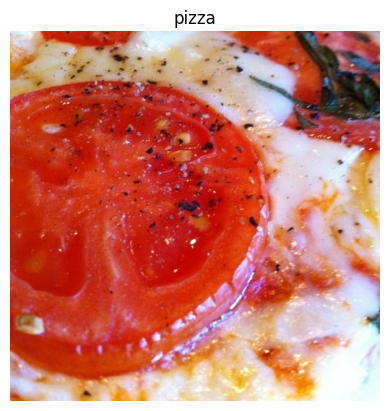

In [13]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

### 2. Tiền xử lý dữ liệu 



In [14]:


# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 3. Tạo  model

In [15]:


# Create our model (a clone of model_8, except to be multi-class)
model_9 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_9.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### 4. Fit  model



In [16]:
# Fit the model
history_9 = model_9.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 29s 120ms/step - loss: 2.1496 - accuracy: 0.2064 - val_loss: 2.0147 - val_accuracy: 0.2816
Epoch 2/5
235/235 [==============================] - 22s 93ms/step - loss: 1.9520 - accuracy: 0.3073 - val_loss: 1.8753 - val_accuracy: 0.3532
Epoch 3/5
235/235 [==============================] - 22s 93ms/step - loss: 1.7790 - accuracy: 0.3779 - val_loss: 1.8421 - val_accuracy: 0.3544
Epoch 4/5
235/235 [==============================] - 22s 93ms/step - loss: 1.5484 - accuracy: 0.4689 - val_loss: 1.8103 - val_accuracy: 0.3756
Epoch 5/5
235/235 [==============================] - 22s 94ms/step - loss: 1.1956 - accuracy: 0.5887 - val_loss: 2.1711 - val_accuracy: 0.3352


### 5. Đánh giá  model



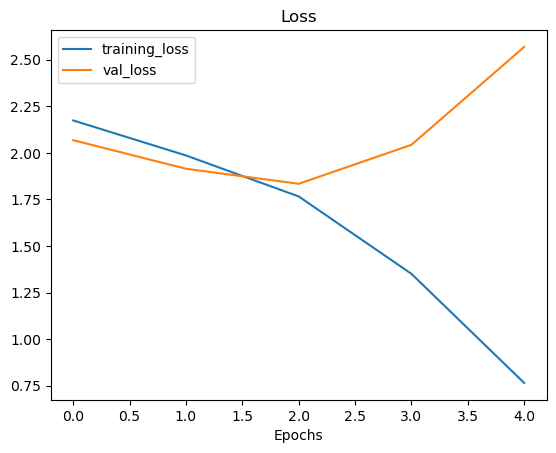

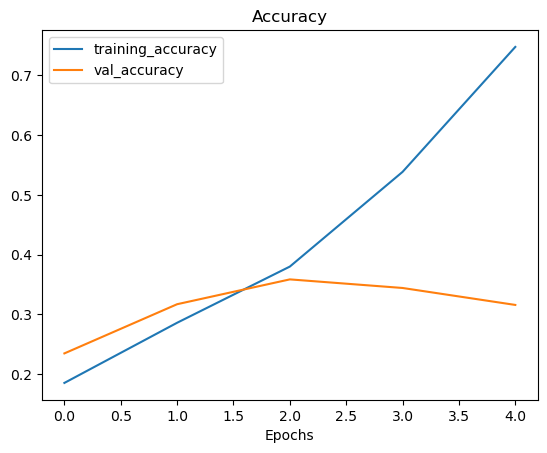

In [95]:
# Check out the model's loss curves on the 10 classes of data (note: this function comes from above in the notebook)
plot_loss_curves(history_9)